In [1]:
import numpy as np
from numpy import array, argmax
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetV2S
from keras.applications.efficientnet_v2 import preprocess_input
from keras.utils import load_img, img_to_array, to_categorical, image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import MaxPooling2D, Flatten, Dense, Dropout, Conv2D, Input, Rescaling, RandomFlip, SpatialDropout2D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import os
from PIL import Image
import pickle
from pickle import dump

In [2]:
imagefolder = 'E:/Documents/knit_stitch_identifier/images/'
# testfolder = '/test/'
check = 'E:/Documents/knit_stitch_identifier/images/Brioche_Rib/'
imagesize = 124

In [3]:
images = image_dataset_from_directory(
    imagefolder,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(imagesize,imagesize),
    shuffle=True,
    seed = 2,
    validation_split = 0.1,
    subset='training'
)

Found 302 files belonging to 32 classes.
Using 272 files for training.


In [4]:
validation_images = image_dataset_from_directory(
    imagefolder,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(imagesize,imagesize),
    shuffle=True,
    seed=2,
    validation_split=0.1,
    subset='validation'
)

Found 302 files belonging to 32 classes.
Using 30 files for validation.


In [5]:
classes = images.class_names

In [6]:
len(classes)

32

In [6]:
import random

def set_random_seed(seed):
    
    '''Random seeds for reproducability'''
    
    random.seed(seed)
    tf.random.set_seed(seed)

In [7]:
set_random_seed(2)
input1 = Input(shape=(imagesize, imagesize, 3))
rescale = Rescaling(1./255, input_shape=(imagesize, imagesize, 3))(input1)
flip = RandomFlip('horizontal_and_vertical')(rescale)
spadrop = SpatialDropout2D(0.6)(flip)
conv = Conv2D(32, kernel_size=(3, 3), activation = 'relu', 
              input_shape = (imagesize, imagesize, 3), kernel_regularizer='l2')(spadrop)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
flat = Flatten()(pool)
fe1 = Dropout(0.8)(flat)
output = Dense(32, activation='softmax', kernel_regularizer='l2')(fe1)

model = Model(inputs = input1, outputs = output)

In [8]:
# early_stop = EarlyStopping(monitor='val_loss', 
#                            patience=2, 
#                            mode='min', 
#                            verbose=1)

model.compile(loss = 'categorical_crossentropy', 
                  optimizer = Adam(learning_rate=0.00001), 
                  metrics = ['accuracy'],
                  run_eagerly=True)

In [9]:
history = model.fit(images,
            epochs = 1000,
            verbose=1,
            validation_data = validation_images
)
model.save('model1.h5')

Epoch 1/1000
9/9 [==============================] - 4s 206ms/step - loss: 4.4279 - accuracy: 0.0368 - val_loss: 4.2025 - val_accuracy: 0.0333
Epoch 2/1000
9/9 [==============================] - 2s 182ms/step - loss: 4.5013 - accuracy: 0.0441 - val_loss: 4.1855 - val_accuracy: 0.0000e+00
Epoch 3/1000
9/9 [==============================] - 2s 170ms/step - loss: 4.4506 - accuracy: 0.0184 - val_loss: 4.1787 - val_accuracy: 0.0000e+00
Epoch 4/1000
9/9 [==============================] - 2s 168ms/step - loss: 4.3333 - accuracy: 0.0441 - val_loss: 4.1669 - val_accuracy: 0.0000e+00
Epoch 5/1000
9/9 [==============================] - 2s 168ms/step - loss: 4.3739 - accuracy: 0.0515 - val_loss: 4.1728 - val_accuracy: 0.0000e+00
Epoch 6/1000
9/9 [==============================] - 2s 170ms/step - loss: 4.4702 - accuracy: 0.0294 - val_loss: 4.1734 - val_accuracy: 0.0000e+00
Epoch 7/1000
9/9 [==============================] - 2s 169ms/step - loss: 4.4557 - accuracy: 0.0221 - val_loss: 4.1748 - val_acc

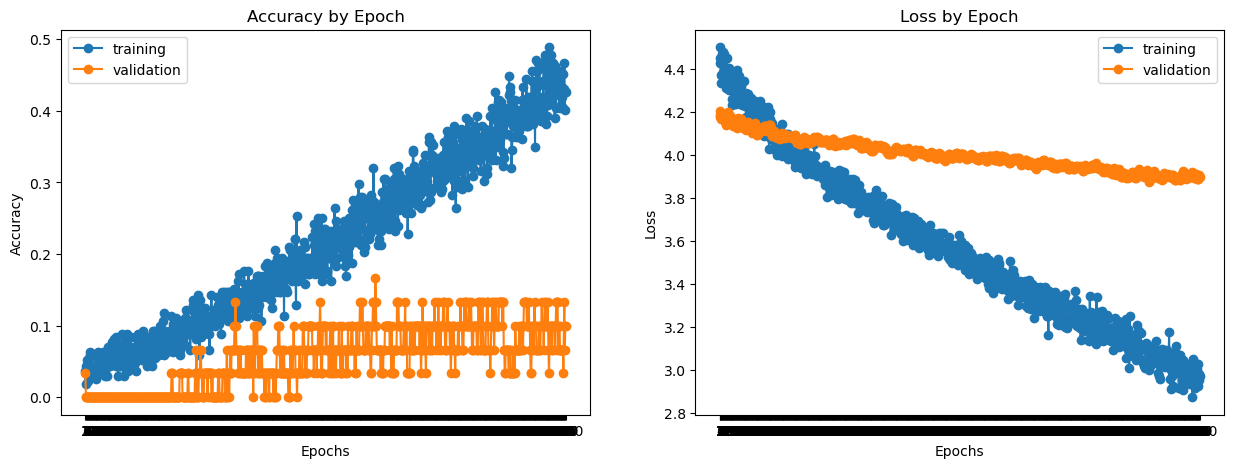

In [10]:
epochs = range(1, 1001)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history["accuracy"], label="training", marker="o")
plt.plot(epochs, history.history["val_accuracy"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Accuracy")
plt.title('Accuracy by Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history["loss"], label="training", marker="o")
plt.plot(epochs, history.history["val_loss"], label="validation", marker="o")
plt.xlabel("Epochs")
plt.xticks(epochs)
plt.ylabel("Loss")
plt.title('Loss by Epoch')
plt.legend()
plt.show()

I think it'll just be better to gather more data. I will do that and then come back.

In [9]:
basemodel = EfficientNetV2S(
    weights='imagenet',
    include_preprocessing=True,
    include_top=False,
    input_shape=(imagesize, imagesize, 3)
)
for layer in basemodel.layers:
    layer.trainable = False
basemodel.summary()

Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 124, 124, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 124, 124, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 62, 62, 24)   648         ['rescaling[0][0]']              
                                                                                                  
 stem_bn (BatchNormalization)   (None, 62, 62, 24)   96          ['stem_conv[0][0]'

In [20]:
with open('features.pkl', 'rb') as f:
    batch_features = pickle.load(f)